In [1]:
import glob
import pandas as pd
import os
from collections import deque
from sortedcontainers import SortedDict
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# # Add header to csv file (because every file except the first one doesnt have header)
# header = "agent,event,timestep,goal_reached,timestep_to_goal,collisions_to_goal,collisions,agent_collisions_to_goal,agent_collisions,learning_score"

# dir_name = "2018_05_24_141641_100sim_100000timesteps/"

# count = 0
# for file in glob.glob(dir_name + "*.csv"):
#     if os.stat(file).st_size == 0:
#         print('empty file', file)
#         continue
    
#     with open(file, 'r+') as f:
#         file_data = f.read()
#         f.seek(0, 0)
#         f.write(header.rstrip('\r\n') + '\n' + file_data)


In [3]:
def simp_means(Y):
    N = 10
    
    # Get average timestep by goal reached
    widow = deque(maxlen=N)
    simple_means = []
    for i in Y:
        widow.append(i)
        SM = sum(widow) / (len(widow) + 0.)
        simple_means.append(SM)
        
    return simple_means

def expo_means(Y):

    # Get exponential mean timestep by goal reached
    exponential_means = []
    N = 10
    alpha = 2. / (1. + N)

    # Calculate first point using Simple Mean
    w = deque(maxlen=N)
    for i in xrange(N):
        w.append(Y[i])
        SM = sum(w) / (len(w) + 0.)
        exponential_means.append(SM)
        old_EMA = SM

    # Now do EMA
    for i in xrange(N, len(Y)):
        EMA = old_EMA + (alpha * (Y[i] - old_EMA))
        exponential_means.append(EMA)
        old_EMA = EMA
    
    return exponential_means

def add_fill_fixed_timestep(start, stop, step, dico):
        # Adding fixed-timesteps
        for i in xrange(start, stop + step, step):
            key = i
            if not key in dico:
                dico[i] = None

        # Filling fixed-timesteps with previous value
        for i in xrange(len(dico)):
            if i == 0:
                dico[i] = 0
            else:
                key = dico.peekitem(i)[0]
                value = dico.peekitem(i)[1]
                if value is None:
                    prev_value = dico.peekitem(i-1)[1]
                    dico[key] = prev_value

# Remove the recorded timesteps, keep only the fixed-timesteps
def remove_recorded_timesteps(data_rm, x_fixed, dico):
    for key in data_rm:
        if not key in x_fixed:
            del dico[key]
            
def get_yfixed(start, stop, step, dico):
    x_fixed = range(start, stop + step, step)
    y_fixed = []
    for i in x_fixed:
        value = dico[i]
        
        y_fixed.append(value)
#         if value != 0:
#             x_fixed.append(i)
#             y_fixed.append(value)
    return y_fixed

def blabla(X, exponential_means, start, stop, step):
    
    # Using SortedDict
    dictio = SortedDict({})

    # Initial key-value (key : recorded-timesteps, value : EMA)
    for i in xrange(len(X)):
        dictio[X[i]] = exponential_means[i]

    x_fixed = range(start, stop + step, step)
    
    add_fill_fixed_timestep(start=start, stop=stop, step=step, dico=dictio)
    remove_recorded_timesteps(X, x_fixed, dictio)
    
    return get_yfixed(start=start, stop=stop, step=step, dico=dictio)

In [4]:
dir_name = "2018_05_24_141641_100sim_100000timesteps/"
df_list = []
X_list = []
Y_list = []
exponential_means_list = []
simple_means_list = []
Y_list_SMA = []

start = 0
stop = 100000
step = 1000
x_fixed = range(start, stop + step, step)

# For each simulation file
for f in glob.glob(dir_name + "*.csv"):
    if os.stat(f).st_size == 0:
        print('empty file', f)
        continue
    
    data = pd.read_csv(f)
    df_list.append(data)
    
    # Get data Timestep
    X = data[data['event'].str.startswith('reached goal')]['timestep']
    
    # Get data Timestep to Goal
    Y = data[data['event'].str.startswith('reached goal')]['timestep_to_goal']
    
    # EMA
    exponential_means = expo_means(Y)
    exponential_means_list.append(exponential_means)
    
    y_fixed = blabla(X, exponential_means, start=start, stop=stop, step=step)
    Y_list.append(y_fixed)
    
#     # SMA
#     simple_means = simp_means(Y)
#     simple_means_list.append(simple_means)
    
#     y_fixed_SMA = blabla(X, simple_means, start=start, stop=stop, step=step)
#     Y_list_SMA.append(y_fixed_SMA)

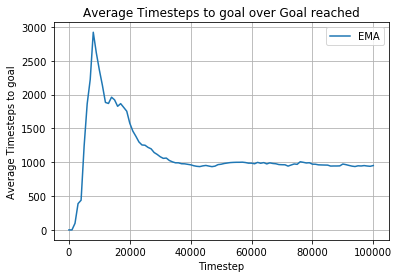

In [5]:
X_Final = x_fixed

# Final Y is average of all list
Y_Final = [sum(e)/len(e) for e in zip(*Y_list)]

# Plot fixed-timestep key-values
plt.plot(X_Final, Y_Final)
plt.xlabel('Timestep')
plt.ylabel('Average Timesteps to goal')
plt.title('Average Timesteps to goal over Goal reached')
plt.legend(['EMA'], loc='upper right')
plt.grid(True)
plt.show()

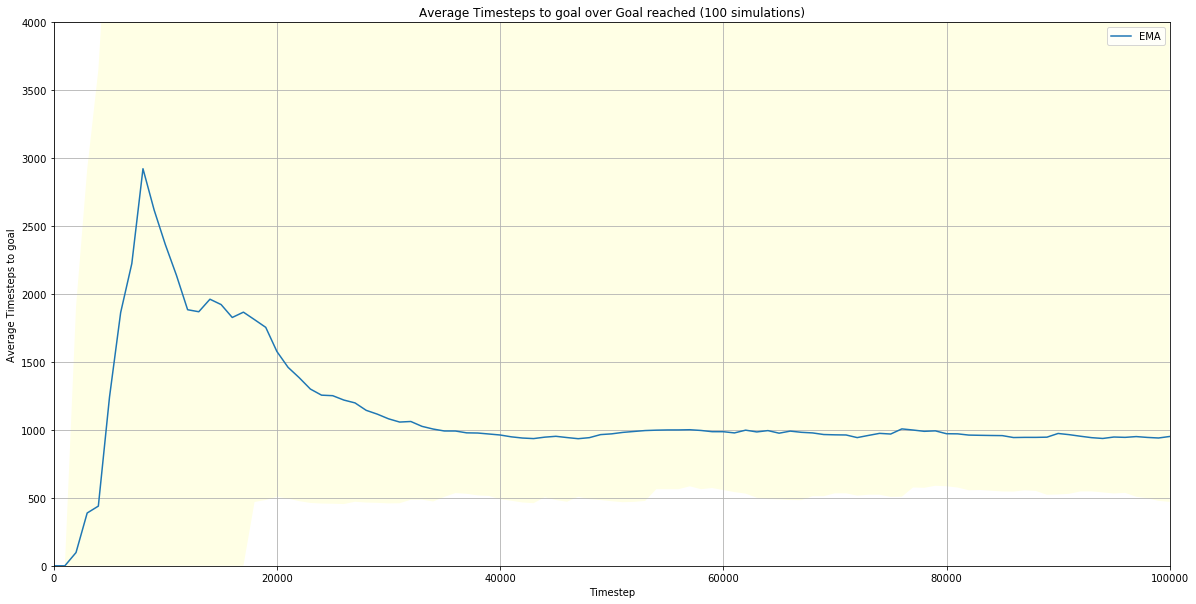

In [9]:
X_Final = x_fixed
Y_Final = [sum(e)/len(e) for e in zip(*Y_list)]


# Get min and max
Y_min = [min(e) for e in zip(*Y_list)]
Y_max = [max(e) for e in zip(*Y_list)]

# Standard deviation
Y_std = [np.std(np.asarray(e)) for e in zip(*Y_list)]
Y_var = [np.var(np.asarray(e)) for e in zip(*Y_list)]
# SMA
Y_Final_SMA = [sum(e)/len(e) for e in zip(*Y_list_SMA)]
Y_min_SMA = [min(e) for e in zip(*Y_list_SMA)]
Y_max_SMA = [max(e) for e in zip(*Y_list_SMA)]



# Plot fixed-timestep key-values
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(X_Final, Y_Final)

# ax.fill_between(X_Final, np.array(Y_Final) + np.array(Y_std), np.array(Y_Final) - np.array(Y_std), 
#                 facecolor='blue', alpha=0.3)

ax.fill_between(X_Final, Y_min, Y_max, facecolor='yellow', alpha=0.1)

#ax.plot(X_Final, Y_Final_SMA)
#ax.fill_between(X_Final, Y_min_SMA, Y_max_SMA, facecolor='yellow', alpha=0.1)
ax.set_xlim(0, 100000)
ax.set_ylim(0, 4000)
ax.set_xlabel('Timestep')
ax.set_ylabel('Average Timesteps to goal')
ax.set_title('Average Timesteps to goal over Goal reached (100 simulations)')
ax.legend(['EMA'], loc='upper right')
ax.grid()
plt.show()

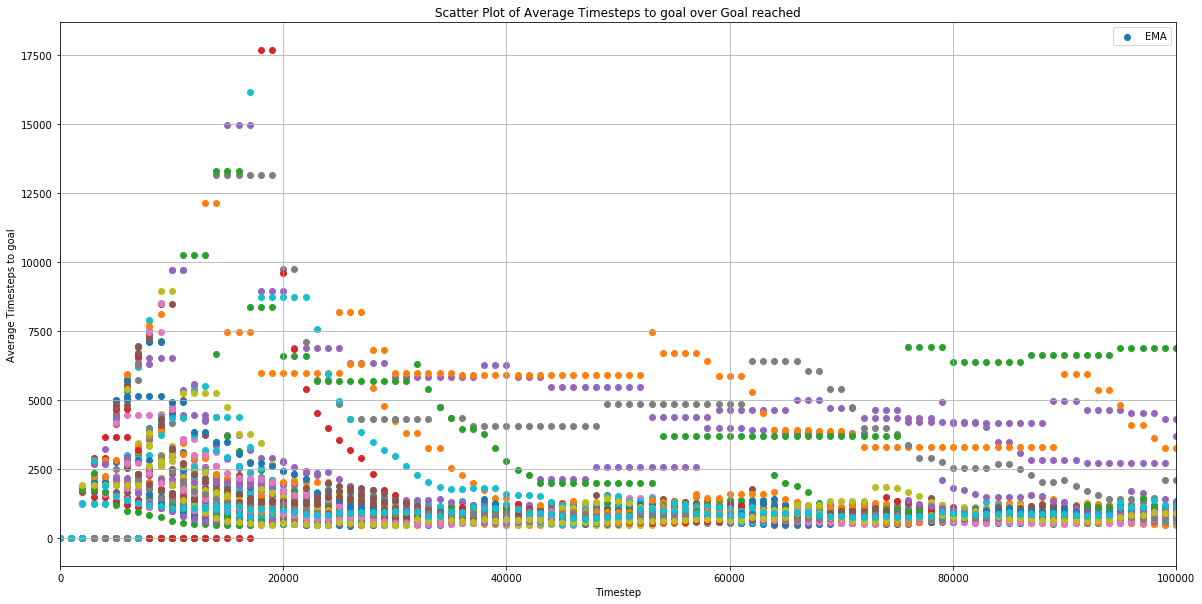

In [10]:
X_Final = x_fixed
#Y_Final = [sum(e)/len(e) for e in zip(*Y_list)]


fig, ax = plt.subplots(figsize=(20, 10))
for i in range(100):
    ax.scatter(X_Final, Y_list[i])

ax.set_xlim(0, 100000)

ax.set_xlabel('Timestep')
ax.set_ylabel('Average Timesteps to goal')
ax.set_title('Scatter Plot of Average Timesteps to goal over Goal reached')
ax.legend(['EMA'], loc='upper right')
ax.grid()

plt.show()